# Impact of temporal resolution of soiling models in energy yield analysis
Monthly soiling profiles are often used in energy yield assessments to estimate the impact of dust and snow on photovoltaic (PV) system performance. However, irradiance and other inputs are provided at hourly intervals. This contradiction in temporal resolution causes errors in annual energy yield predictions. This study investigates the magnitude of the error by comparing annual energy production with daily versus monthly soiling inputs.

In [ ]:
import pathlib
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import pvlib as pvl
import seaborn as sns
import tqdm

mpl.rcParams['figure.figsize'] = (12, 8)
sns.set(font_scale=1.5)

In [2]:
tmy3_path = pathlib.Path("C:/Users/ADMMIKM/Downloads/weather/NSRDB/1991-2005/tmy3")
alltmy3 = tmy3_path / "alltmy3a"
tmy3_stations_meta = tmy3_path / "TMY3_StationsMeta(1).csv"
tmy3_stations_meta = pd.read_csv(tmy3_stations_meta)
tmy3_stations_meta.head()


,USAF,Site Name,State,Latitude,Longitude,TZ,Elev,Class,Pool
0,690150,TWENTYNINE PALMS,CA,34.300,-116.167,-8,626,II,12
1,690190,ABILENE DYESS AFB,TX,32.433,-99.850,-6,545,II,12
2,690230,WHIDBEY ISLAND NAS,WA,48.350,-122.667,-8,10,II,12
3,699604,YUMA MCAS,AZ,32.650,-114.617,-7,65,II,12
4,700197,SELAWIK,AK,66.600,-160.000,-9,8,III,11


In [3]:
def get_soiling_profiles(tmy3df, rate=0.0010, grace=1, rainthresh=4):
    precip = tmy3df['Lprecip depth (mm)']
    soiling = pvl.soiling.kimber(
        precip, soiling_loss_rate=rate, grace_period=grace,
        cleaning_threshold=rainthresh)
    return soiling

In [4]:
def get_fixedtilt_energy(tmy3df, meta, soiling, fixed_tilt=30.0, system_azimuth=180,
                         eta=0.2, utherm=[25.0, 1.2], dc=1e6, ac=800e3, gamma=-0.004):
    times = tmy3df.index.shift(freq='-30min')
    dni = tmy3df['dni'].values
    ghi = tmy3df['ghi'].values
    dhi = tmy3df['dhi'].values
    press = tmy3df['pressure'].values * 100  # convert from mbar to Pa
    airtemp = tmy3df['temp_air'].values
    windspeed = tmy3df['wind_speed'].values
    solar_position = pvl.solarposition.get_solarposition(
        times, meta['latitude'], meta['longitude'], altitude=meta['altitude'],
        pressure=press, temperature=airtemp)
    dni_extra = pvl.irradiance.get_extra_radiation(times)
    dni_extra.name = 'dni_extra'
    poa_irradiance = pvl.irradiance.get_total_irradiance(
        surface_tilt=fixed_tilt,
        surface_azimuth=system_azimuth,
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'],
        dni=dni, ghi=ghi, dhi=dhi, dni_extra=dni_extra,
        model='haydavies')
    cell_temperature = pvl.temperature.pvsyst_cell(
        poa_irradiance['poa_global'],
        temp_air=airtemp,
        wind_speed=windspeed,
        module_efficiency=eta,
        u_c=utherm[0], u_v=utherm[1])
    cell_temperature.name = 'cell_temperature'
    effective_irradiance = poa_irradiance['poa_global'] * (1-soiling.values)
    effective_irradiance.name = 'effective_irradiance'
    dc_energy = pvl.pvsystem.pvwatts_dc(
        effective_irradiance=effective_irradiance,
        temp_cell=cell_temperature, pdc0=dc, gamma_pdc=gamma)
    dc_energy.name = 'dc_energy'
    ac_energy = pvl.inverter.pvwatts(dc_energy, pdc0=ac)
    ac_energy.name = 'ac_energy'
    df = pd.concat([
        solar_position,
        dni_extra,
        poa_irradiance,], axis=1)
    df = pd.concat([df, cell_temperature,
                    effective_irradiance,
                    dc_energy,
                    ac_energy], axis=1)
    df.index = tmy3df.index
    return df

{'USAF': 690150, 'Name': '"TWENTYNINE PALMS"', 'State': 'CA', 'TZ': -8.0, 'latitude': 34.3, 'longitude': -116.167, 'altitude': 626.0}


C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\503117394.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_soil_tp = soiling_tp.resample('ME').mean().shift(freq='-1M').shift(freq='1D')
C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\503117394.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  monthly_soil_tp = monthly_soil_tp.resample('H').ffill().iloc[:-1]


Total AC Energy (Hourly Soiling FF): 1929883616.0321608
Total AC Energy (Monthly Soiling FF): 1931269046.4117131
Difference: -1385430.3795523643
Percentage Difference: -0.07%


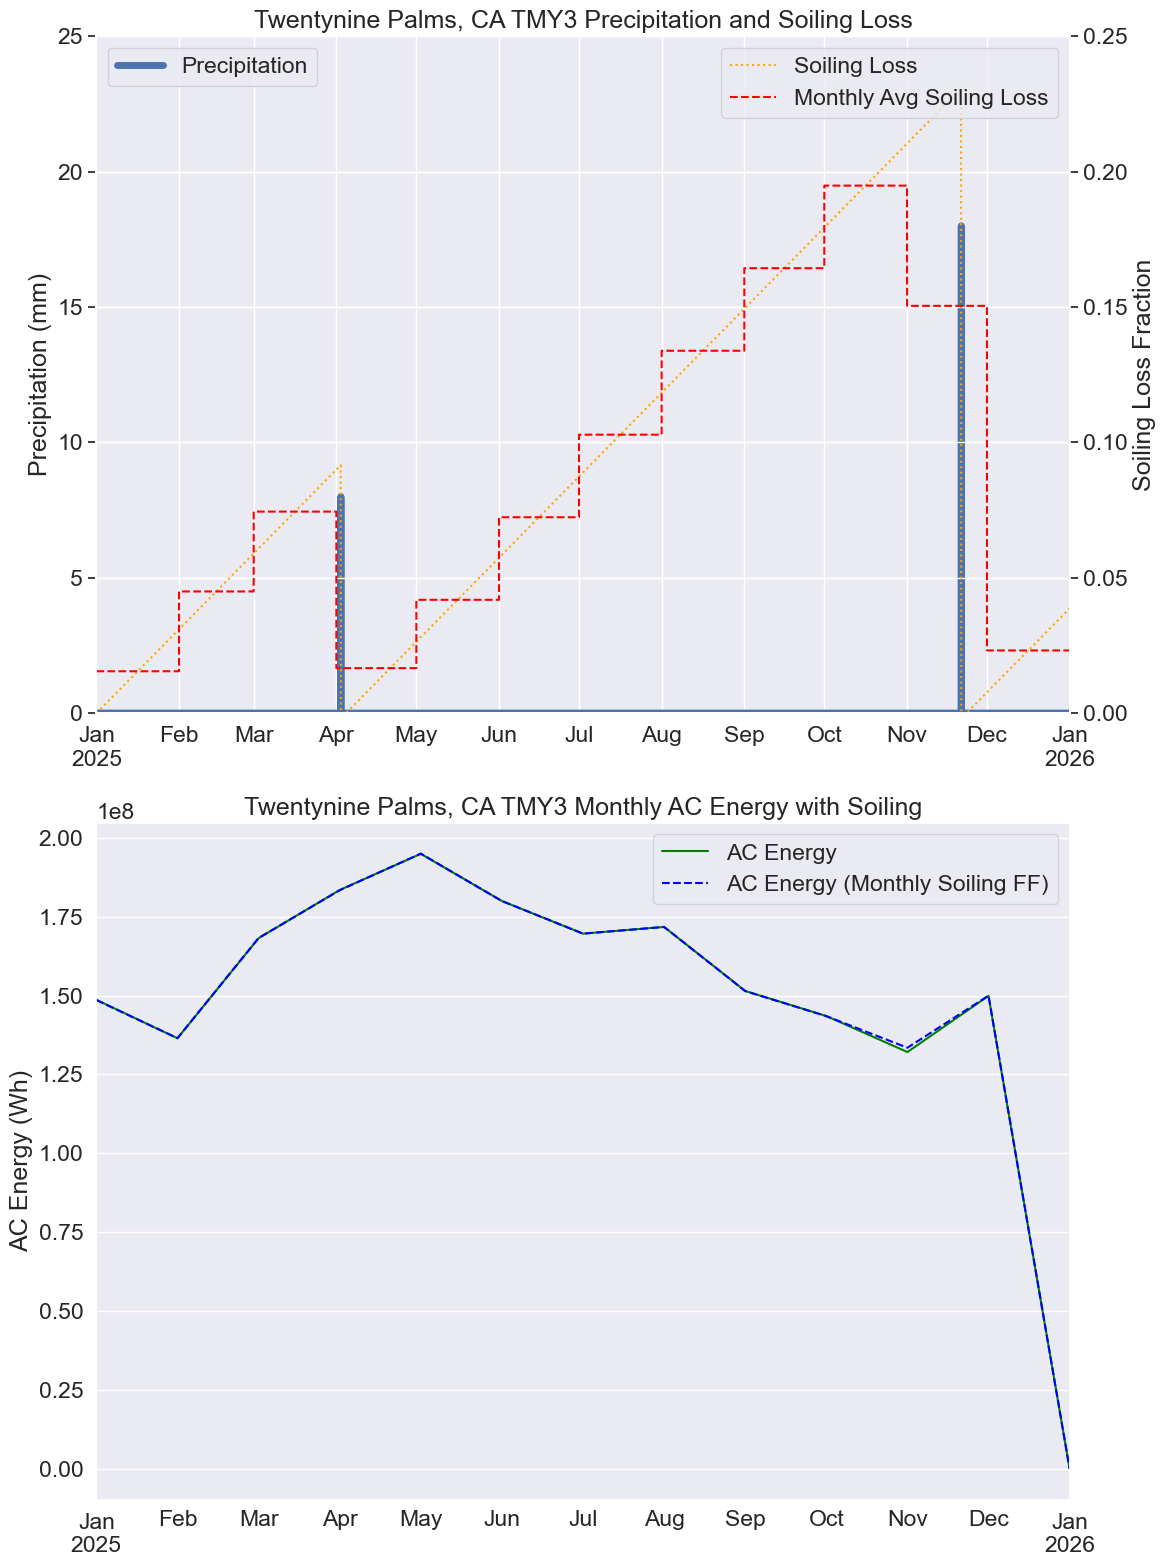

In [12]:
twentynine_palms, meta_tp = pvl.iotools.read_tmy3(
    filename=(alltmy3 / "690150TYA.CSV"),
    coerce_year=2025)

print(meta_tp)

soiling_tp = get_soiling_profiles(twentynine_palms)

fixedtilt_tp = get_fixedtilt_energy(
    twentynine_palms, meta_tp, soiling_tp)

monthly_soil_tp = soiling_tp.resample('ME').mean().shift(freq='-1M').shift(freq='1D')
monthly_soil_tp = monthly_soil_tp.resample('H').ffill().iloc[:-1]
monthly_ff_tp = get_fixedtilt_energy(
    twentynine_palms, meta_tp, monthly_soil_tp)


f, a = plt.subplots(2, 1, figsize=(12, 16))

twentynine_palms['Lprecip depth (mm)'].plot(ax=a[0], linewidth=5, label='Precipitation')
atwin = a[0].twinx()
soiling_tp.plot(
    ax=atwin, color='orange', label='Soiling Loss', linestyle=':')
monthly_soil_tp.plot(
    ax=atwin, color='red', linestyle='--', label='Monthly Avg Soiling Loss',
    drawstyle='steps-post')
a[0].set_title('Twentynine Palms, CA TMY3 Precipitation and Soiling Loss')
a[0].set_ylabel('Precipitation (mm)')
atwin.set_ylabel('Soiling Loss Fraction')
a[0].legend(loc='upper left')
atwin.legend(loc='upper right')
a[0].set_ylim(0, 25)
atwin.set_ylim(0, 0.25)
fixedtilt_tp['ac_energy'].resample('ME').sum().plot(
    ax=a[1], color='green', label='AC Energy')
monthly_ff_tp['ac_energy'].resample('ME').sum().plot(
    ax=a[1], color='blue', linestyle='--', label='AC Energy (Monthly Soiling FF)')
a[1].set_title('Twentynine Palms, CA TMY3 Monthly AC Energy with Soiling')
a[1].set_ylabel('AC Energy (Wh)')
a[1].legend()
f.tight_layout()

print(f"Total AC Energy (Hourly Soiling FF): {fixedtilt_tp['ac_energy'].sum()}")
print(f"Total AC Energy (Monthly Soiling FF): {monthly_ff_tp['ac_energy'].sum()}")
print(f"Difference: {fixedtilt_tp['ac_energy'].sum() - monthly_ff_tp['ac_energy'].sum()}")
print(f"Percentage Difference: {100 * (fixedtilt_tp['ac_energy'].sum() - monthly_ff_tp['ac_energy'].sum()) / fixedtilt_tp['ac_energy'].sum():.2f}%")

{'USAF': 690230, 'Name': '"WHIDBEY ISLAND NAS"', 'State': 'WA', 'TZ': -8.0, 'latitude': 48.35, 'longitude': -122.667, 'altitude': 10.0}


C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\263600464.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_soil_wi = soiling_wi.resample('ME').mean().shift(freq='-1M').shift(freq='1D')
C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\263600464.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  monthly_soil_wi = monthly_soil_wi.resample('H').ffill().iloc[:-1]


Total AC Energy (Hourly Soiling FF): 1333492627.3479447
Total AC Energy (Monthly Soiling FF): 1334032967.9454367
Difference: -540340.5974919796
Percentage Difference: -0.04%


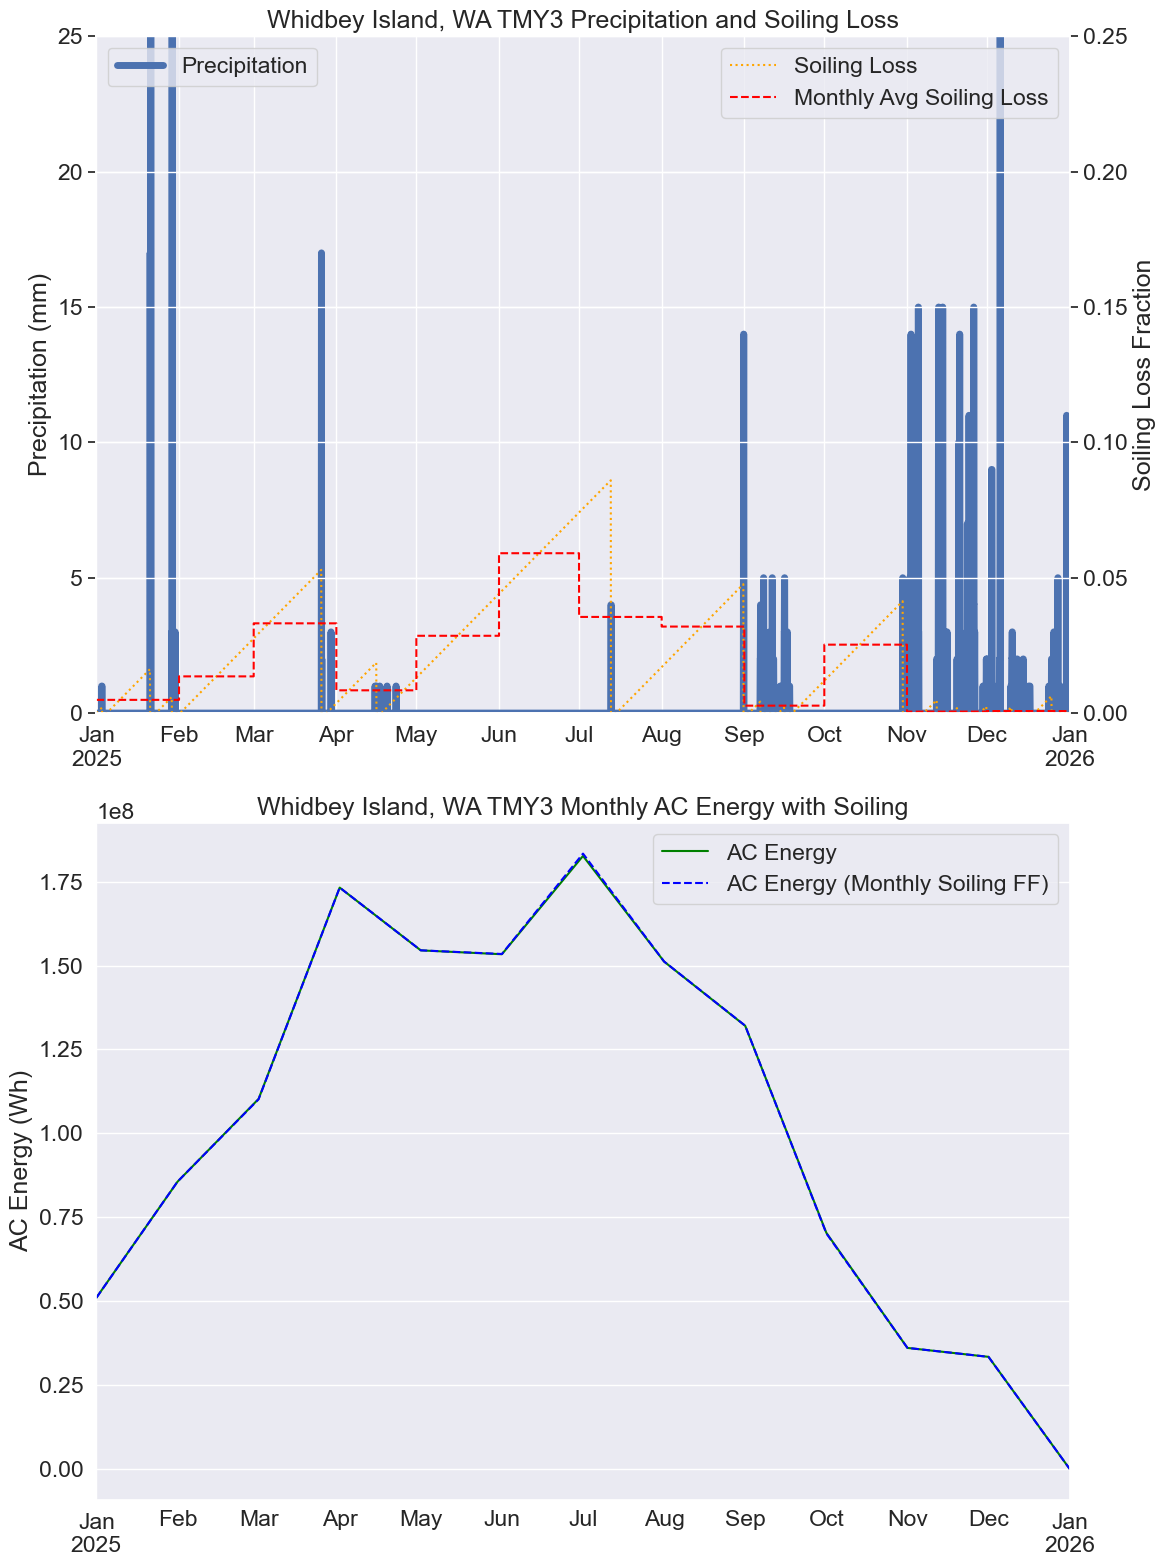

In [13]:
whidbey_isle, meta_wi = pvl.iotools.read_tmy3(
    filename=(alltmy3 / "690230TYA.CSV"),
    coerce_year=2025)

print(meta_wi)

soiling_wi = get_soiling_profiles(whidbey_isle)

fixedtilt_wi = get_fixedtilt_energy(
    whidbey_isle, meta_wi, soiling_wi)

monthly_soil_wi = soiling_wi.resample('ME').mean().shift(freq='-1M').shift(freq='1D')
monthly_soil_wi = monthly_soil_wi.resample('H').ffill().iloc[:-1]
monthly_ff_wi = get_fixedtilt_energy(
    whidbey_isle, meta_wi, monthly_soil_wi)


f, a = plt.subplots(2, 1, figsize=(12, 16))

whidbey_isle['Lprecip depth (mm)'].plot(ax=a[0], linewidth=5, label='Precipitation')
atwin = a[0].twinx()
soiling_wi.plot(
    ax=atwin, color='orange', label='Soiling Loss', linestyle=':')
monthly_soil_wi.plot(
    ax=atwin, color='red', linestyle='--', label='Monthly Avg Soiling Loss',
    drawstyle='steps-post')
a[0].set_title('Whidbey Island, WA TMY3 Precipitation and Soiling Loss')
a[0].set_ylabel('Precipitation (mm)')
atwin.set_ylabel('Soiling Loss Fraction')
a[0].legend(loc='upper left')
atwin.legend(loc='upper right')
a[0].set_ylim(0, 25)
atwin.set_ylim(0, 0.25)
fixedtilt_wi['ac_energy'].resample('ME').sum().plot(
    ax=a[1], color='green', label='AC Energy')
monthly_ff_wi['ac_energy'].resample('ME').sum().plot(
    ax=a[1], color='blue', linestyle='--', label='AC Energy (Monthly Soiling FF)')
a[1].set_title('Whidbey Island, WA TMY3 Monthly AC Energy with Soiling')
a[1].set_ylabel('AC Energy (Wh)')
a[1].legend()
f.tight_layout()

print(f"Total AC Energy (Hourly Soiling FF): {fixedtilt_wi['ac_energy'].sum()}")
print(f"Total AC Energy (Monthly Soiling FF): {monthly_ff_wi['ac_energy'].sum()}")
print(f"Difference: {fixedtilt_wi['ac_energy'].sum() - monthly_ff_wi['ac_energy'].sum()}")
print(f"Percentage Difference: {100 * (1 - monthly_ff_wi['ac_energy'].sum() / fixedtilt_wi['ac_energy'].sum()):.2f}%")

In [15]:
def calculate_monthly_soiling_ff_impact(tmy3filename):
    weather_data, meta = pvl.iotools.read_tmy3(
        filename=(alltmy3 / tmy3filename),
        coerce_year=2025)

    print(meta)
    name = meta['Name']
    state = meta['State']

    soiling = get_soiling_profiles(weather_data)

    fixedtilt = get_fixedtilt_energy(
        weather_data, meta, soiling)

    monthly_soil = soiling.resample('ME').mean().shift(freq='-1M').shift(freq='1D')
    monthly_soil = monthly_soil.resample('H').ffill().iloc[:-1]
    monthly_ff = get_fixedtilt_energy(
        weather_data, meta, monthly_soil)

    f, a = plt.subplots(2, 1, figsize=(12, 16))

    weather_data['Lprecip depth (mm)'].plot(ax=a[0], linewidth=5, label='Precipitation')
    atwin = a[0].twinx()
    soiling.plot(
        ax=atwin, color='orange', label='Soiling Loss', linestyle=':')
    monthly_soil.plot(
        ax=atwin, color='red', linestyle='--', label='Monthly Avg Soiling Loss',
        drawstyle='steps-post')
    a[0].set_title(f'{name}, {state} TMY3 Precipitation and Soiling Loss')
    a[0].set_ylabel('Precipitation (mm)')
    atwin.set_ylabel('Soiling Loss Fraction')
    a[0].legend(loc='upper left')
    atwin.legend(loc='upper right')
    a[0].set_ylim(0, 25)
    atwin.set_ylim(0, 0.25)
    fixedtilt['ac_energy'].resample('ME').sum().plot(
        ax=a[1], color='green', label='AC Energy')
    monthly_ff['ac_energy'].resample('ME').sum().plot(
        ax=a[1], color='blue', linestyle='--', label='AC Energy (Monthly Soiling FF)')
    a[1].set_title(f'{name}, {state} TMY3 Monthly AC Energy with Soiling')
    a[1].set_ylabel('AC Energy (Wh)')
    a[1].legend()
    f.tight_layout()

    print(f"Total AC Energy (Hourly Soiling FF): {fixedtilt['ac_energy'].sum()}")
    print(f"Total AC Energy (Monthly Soiling FF): {monthly_ff['ac_energy'].sum()}")
    print(f"Difference: {fixedtilt['ac_energy'].sum() - monthly_ff['ac_energy'].sum()}")
    print(f"Percentage Difference: {100 * (1 - monthly_ff['ac_energy'].sum() / fixedtilt['ac_energy'].sum()):.2f}%")

{'USAF': 690150, 'Name': '"TWENTYNINE PALMS"', 'State': 'CA', 'TZ': -8.0, 'latitude': 34.3, 'longitude': -116.167, 'altitude': 626.0}


C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\1973704944.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_soil = soiling.resample('ME').mean().shift(freq='-1M').shift(freq='1D')
C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\1973704944.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  monthly_soil = monthly_soil.resample('H').ffill().iloc[:-1]


Total AC Energy (Hourly Soiling FF): 1929883616.0321608
Total AC Energy (Monthly Soiling FF): 1931269046.4117131
Difference: -1385430.3795523643
Percentage Difference: -0.07%


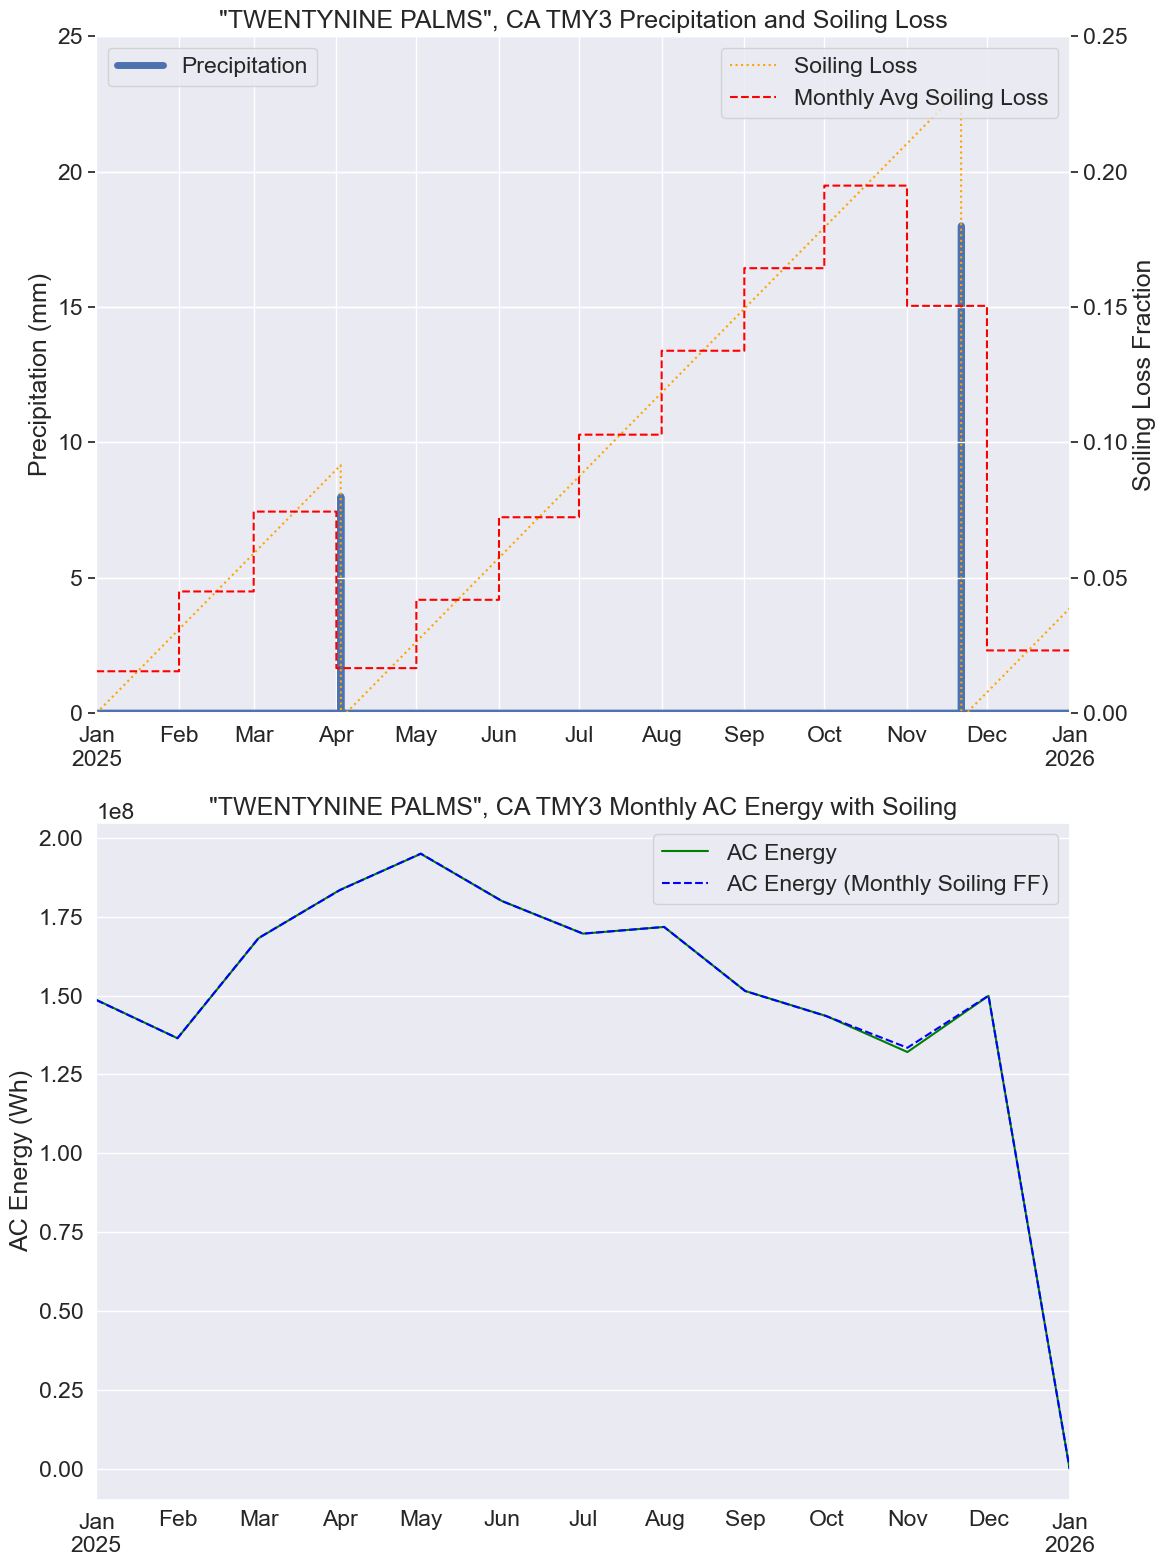

In [16]:
calculate_monthly_soiling_ff_impact("690150TYA.CSV")

{'USAF': 690230, 'Name': '"WHIDBEY ISLAND NAS"', 'State': 'WA', 'TZ': -8.0, 'latitude': 48.35, 'longitude': -122.667, 'altitude': 10.0}


C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\1973704944.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_soil = soiling.resample('ME').mean().shift(freq='-1M').shift(freq='1D')
C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\1973704944.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  monthly_soil = monthly_soil.resample('H').ffill().iloc[:-1]


Total AC Energy (Hourly Soiling FF): 1333492627.3479447
Total AC Energy (Monthly Soiling FF): 1334032967.9454367
Difference: -540340.5974919796
Percentage Difference: -0.04%


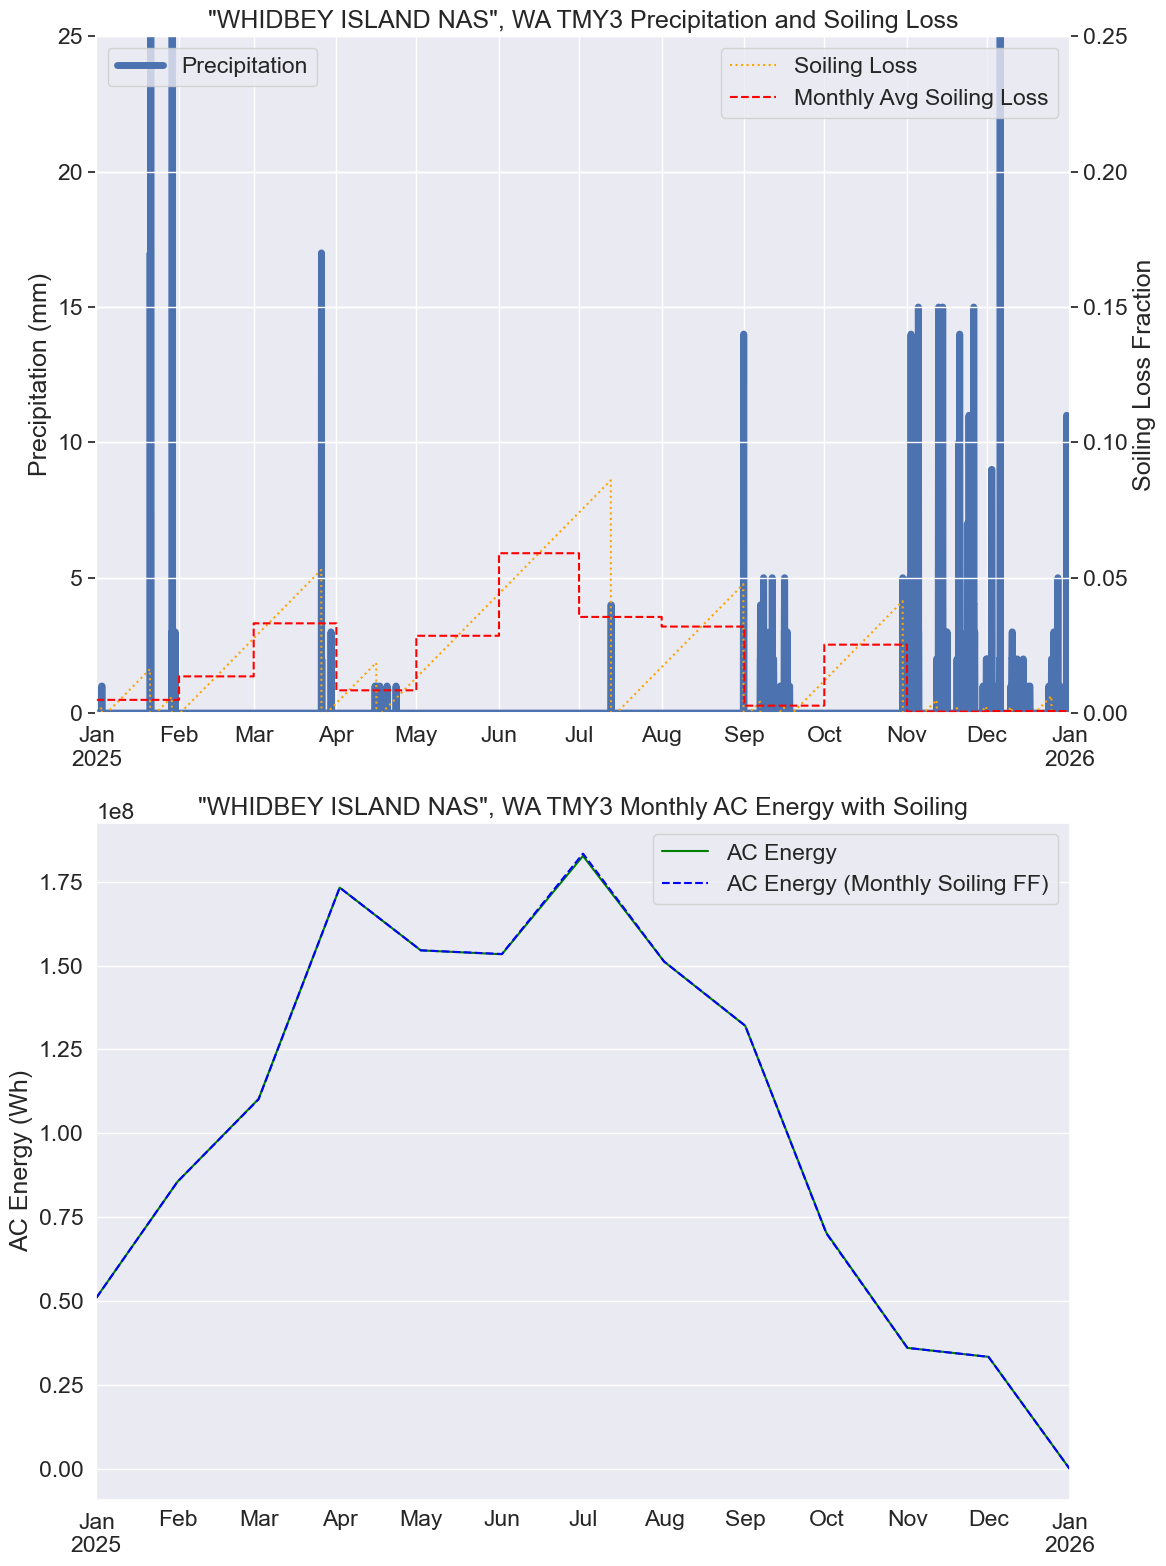

In [17]:
calculate_monthly_soiling_ff_impact("690230TYA.CSV")

{'USAF': 690190, 'Name': '"ABILENE DYESS AFB"', 'State': 'TX', 'TZ': -6.0, 'latitude': 32.433, 'longitude': -99.85, 'altitude': 545.0}


C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\1973704944.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_soil = soiling.resample('ME').mean().shift(freq='-1M').shift(freq='1D')
C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\1973704944.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  monthly_soil = monthly_soil.resample('H').ffill().iloc[:-1]


Total AC Energy (Hourly Soiling FF): 1906063957.170092
Total AC Energy (Monthly Soiling FF): 1906369990.3041682
Difference: -306033.13407611847
Percentage Difference: -0.02%


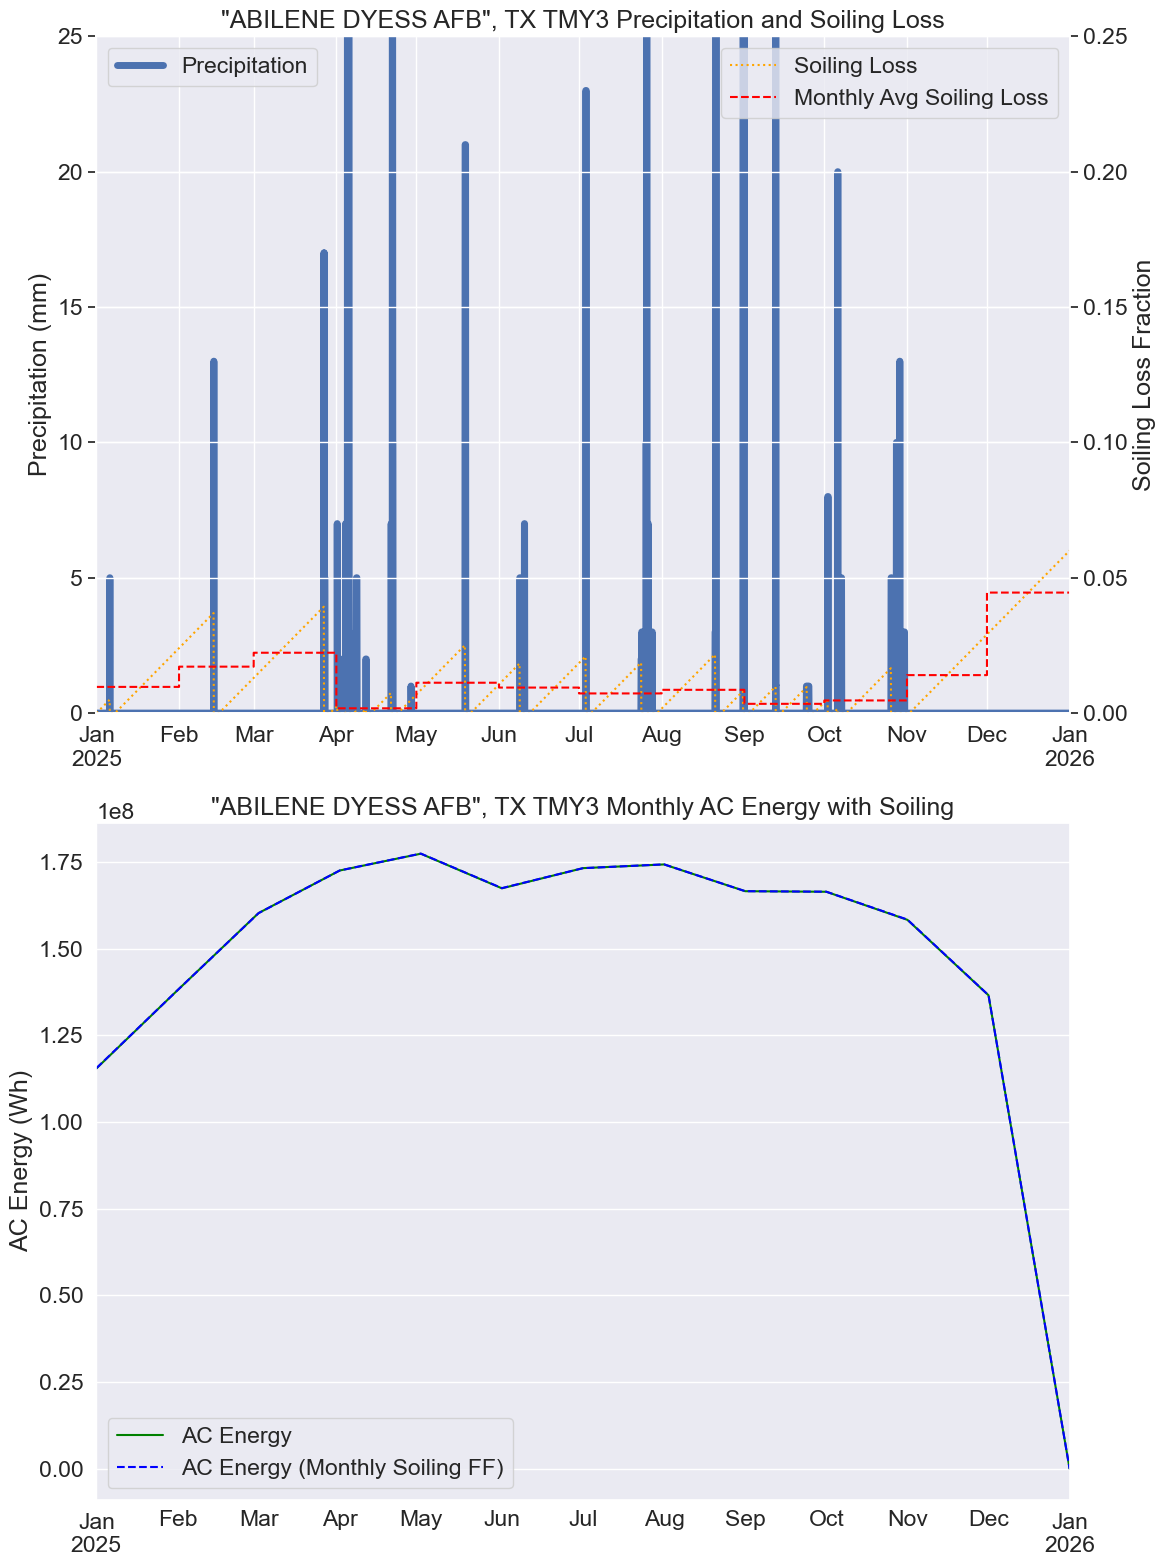

In [18]:
calculate_monthly_soiling_ff_impact("690190TYA.CSV")

{'USAF': 699604, 'Name': '"YUMA MCAS"', 'State': 'AZ', 'TZ': -7.0, 'latitude': 32.65, 'longitude': -114.617, 'altitude': 65.0}


C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\1973704944.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_soil = soiling.resample('ME').mean().shift(freq='-1M').shift(freq='1D')
C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\1973704944.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  monthly_soil = monthly_soil.resample('H').ffill().iloc[:-1]


Total AC Energy (Hourly Soiling FF): 1882215936.7392328
Total AC Energy (Monthly Soiling FF): 1882942233.8078084
Difference: -726297.0685756207
Percentage Difference: -0.04%


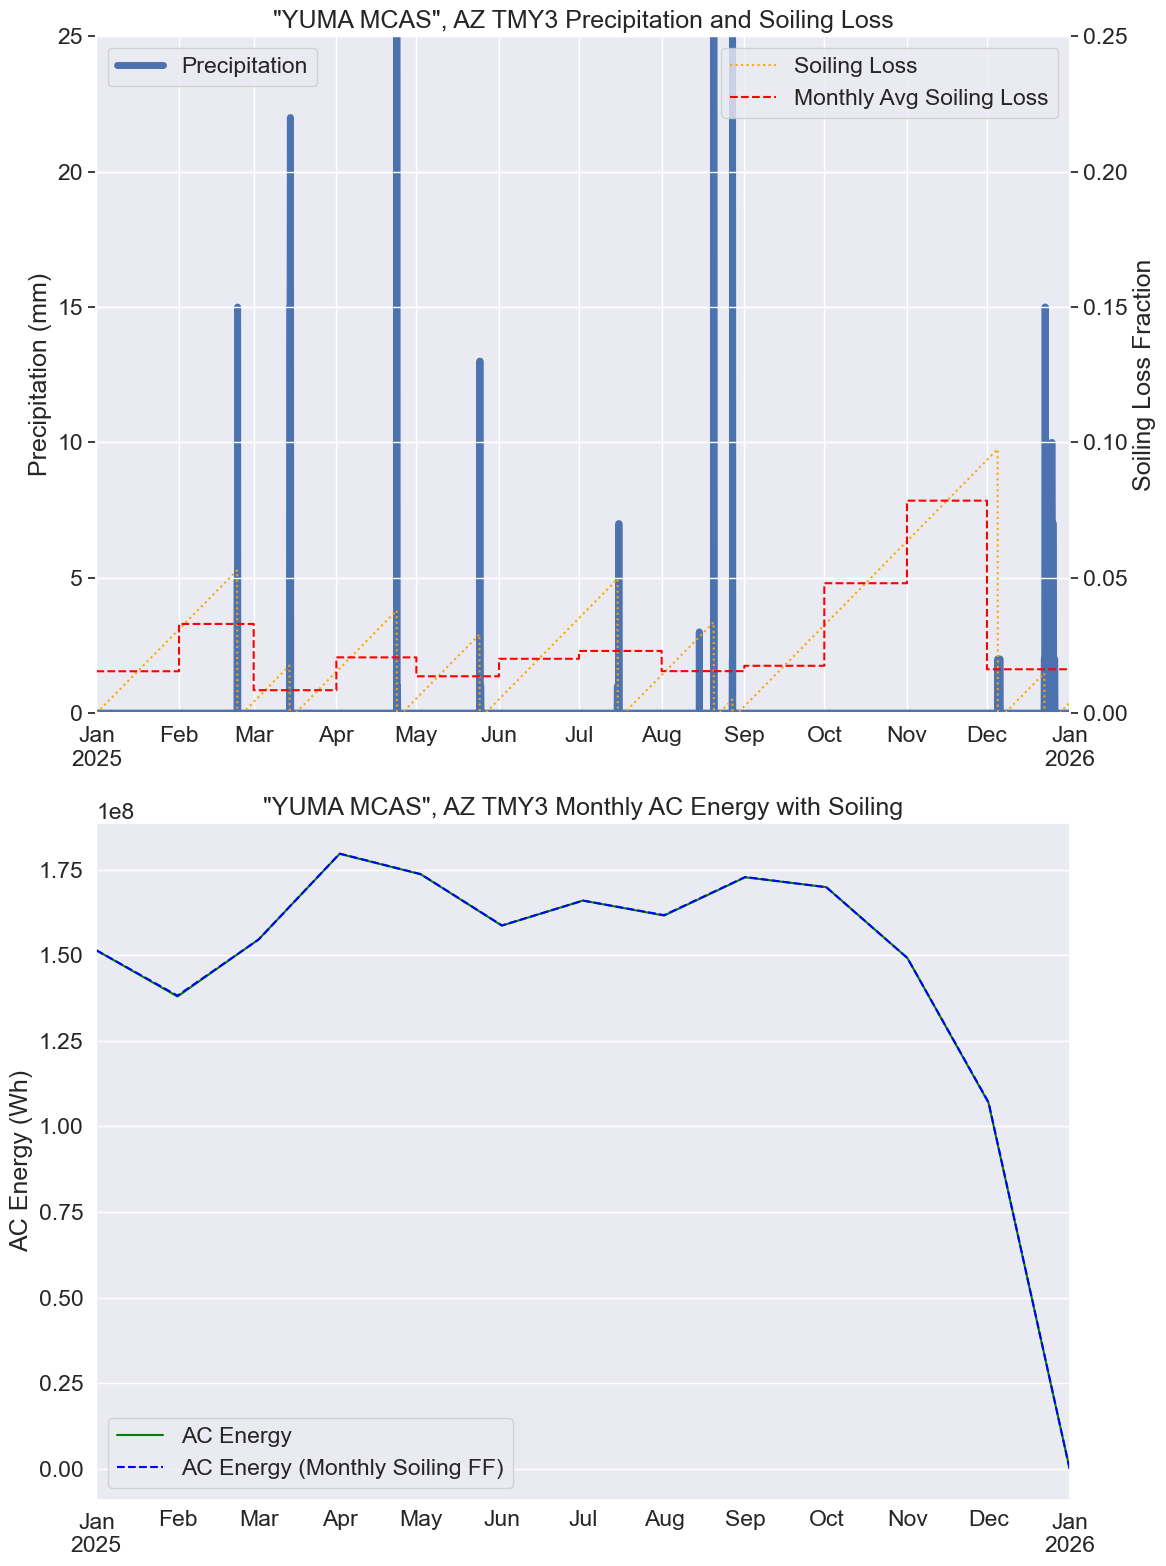

In [19]:
calculate_monthly_soiling_ff_impact("699604TYA.CSV")

{'USAF': 723815, 'Name': '"DAGGETT BARSTOW-DAGGETT AP"', 'State': 'CA', 'TZ': -8.0, 'latitude': 34.85, 'longitude': -116.8, 'altitude': 586.0}


C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\1973704944.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_soil = soiling.resample('ME').mean().shift(freq='-1M').shift(freq='1D')
C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\1973704944.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  monthly_soil = monthly_soil.resample('H').ffill().iloc[:-1]


Total AC Energy (Hourly Soiling FF): 2006971833.3946815
Total AC Energy (Monthly Soiling FF): 2007848538.706017
Difference: -876705.3113355637
Percentage Difference: -0.04%


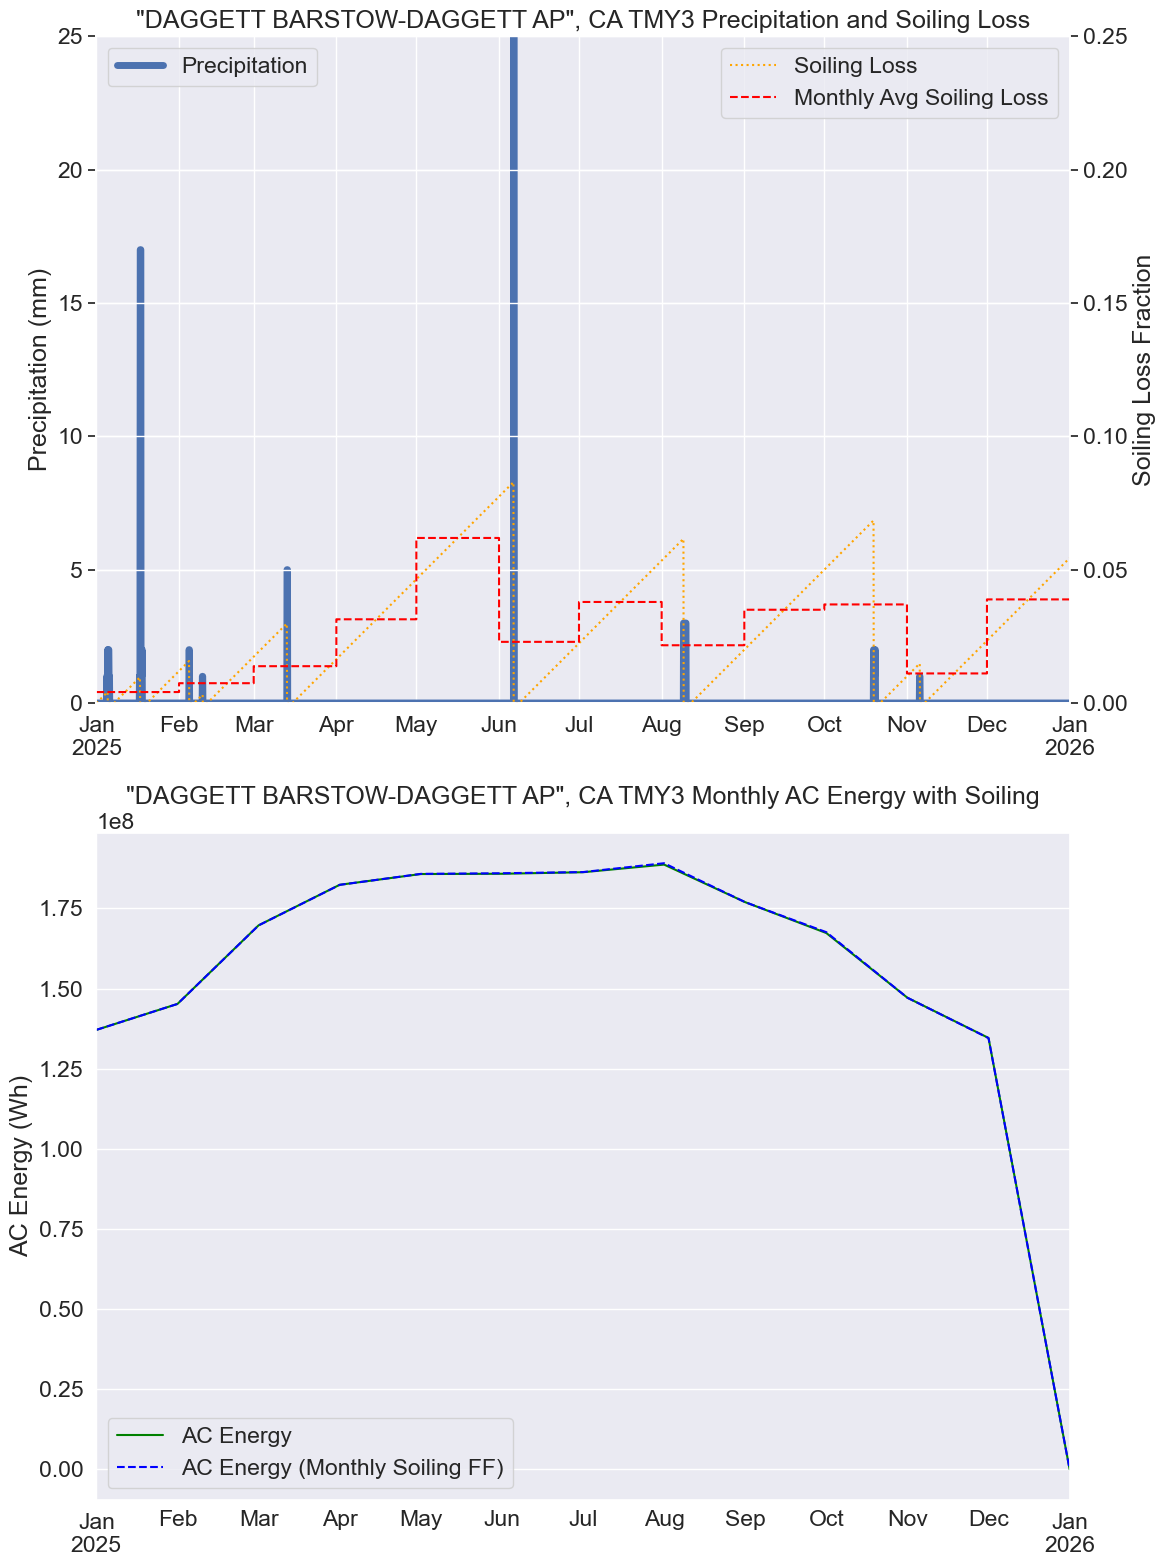

In [20]:
calculate_monthly_soiling_ff_impact("723815TYA.CSV")

{'USAF': 722780, 'Name': '"PHOENIX SKY HARBOR INTL AP"', 'State': 'AZ', 'TZ': -7.0, 'latitude': 33.45, 'longitude': -111.983, 'altitude': 337.0}


C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\1973704944.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_soil = soiling.resample('ME').mean().shift(freq='-1M').shift(freq='1D')
C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\1973704944.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  monthly_soil = monthly_soil.resample('H').ffill().iloc[:-1]


Total AC Energy (Hourly Soiling FF): 1980754957.8928475
Total AC Energy (Monthly Soiling FF): 1981484893.0667408
Difference: -729935.1738932133
Percentage Difference: -0.04%


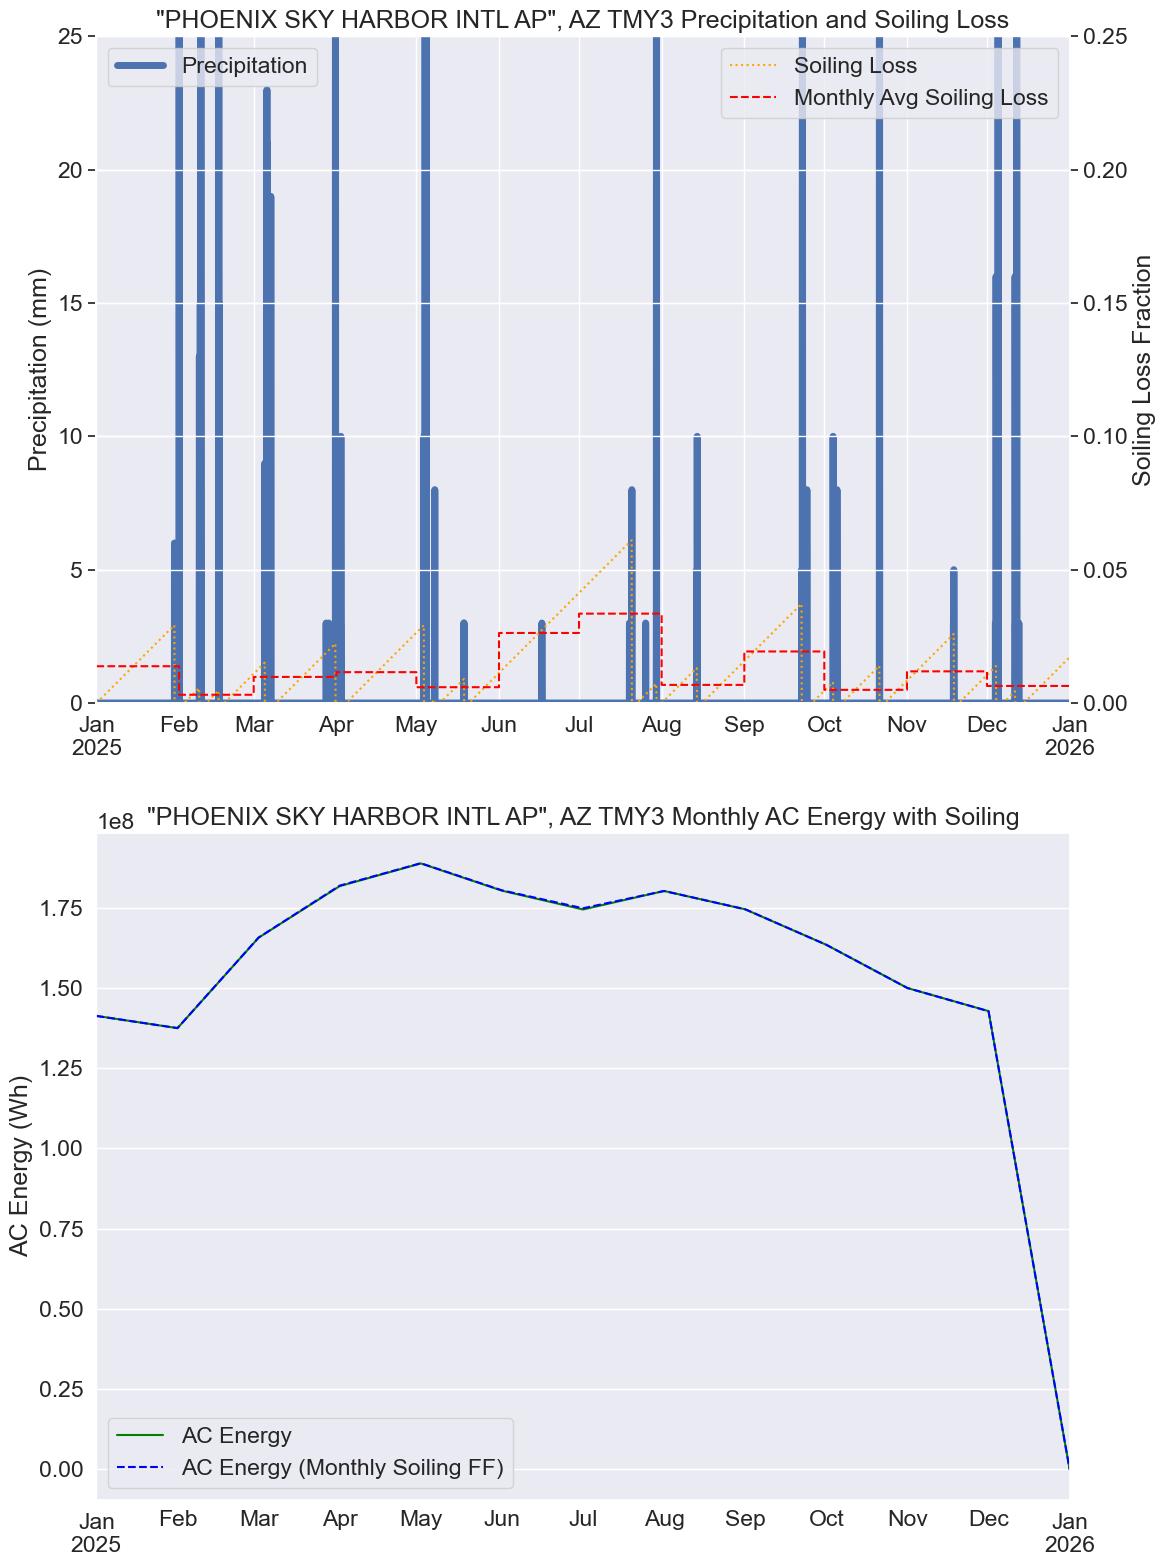

In [21]:
calculate_monthly_soiling_ff_impact("722780TYA.CSV")

{'USAF': 722695, 'Name': '"LAS CRUCES INTL"', 'State': 'NM', 'TZ': -7.0, 'latitude': 32.283, 'longitude': -106.917, 'altitude': 1393.0}


C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\1973704944.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_soil = soiling.resample('ME').mean().shift(freq='-1M').shift(freq='1D')
C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\1973704944.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  monthly_soil = monthly_soil.resample('H').ffill().iloc[:-1]


Total AC Energy (Hourly Soiling FF): 1965141740.467337
Total AC Energy (Monthly Soiling FF): 1965623598.9269867
Difference: -481858.45964980125
Percentage Difference: -0.02%


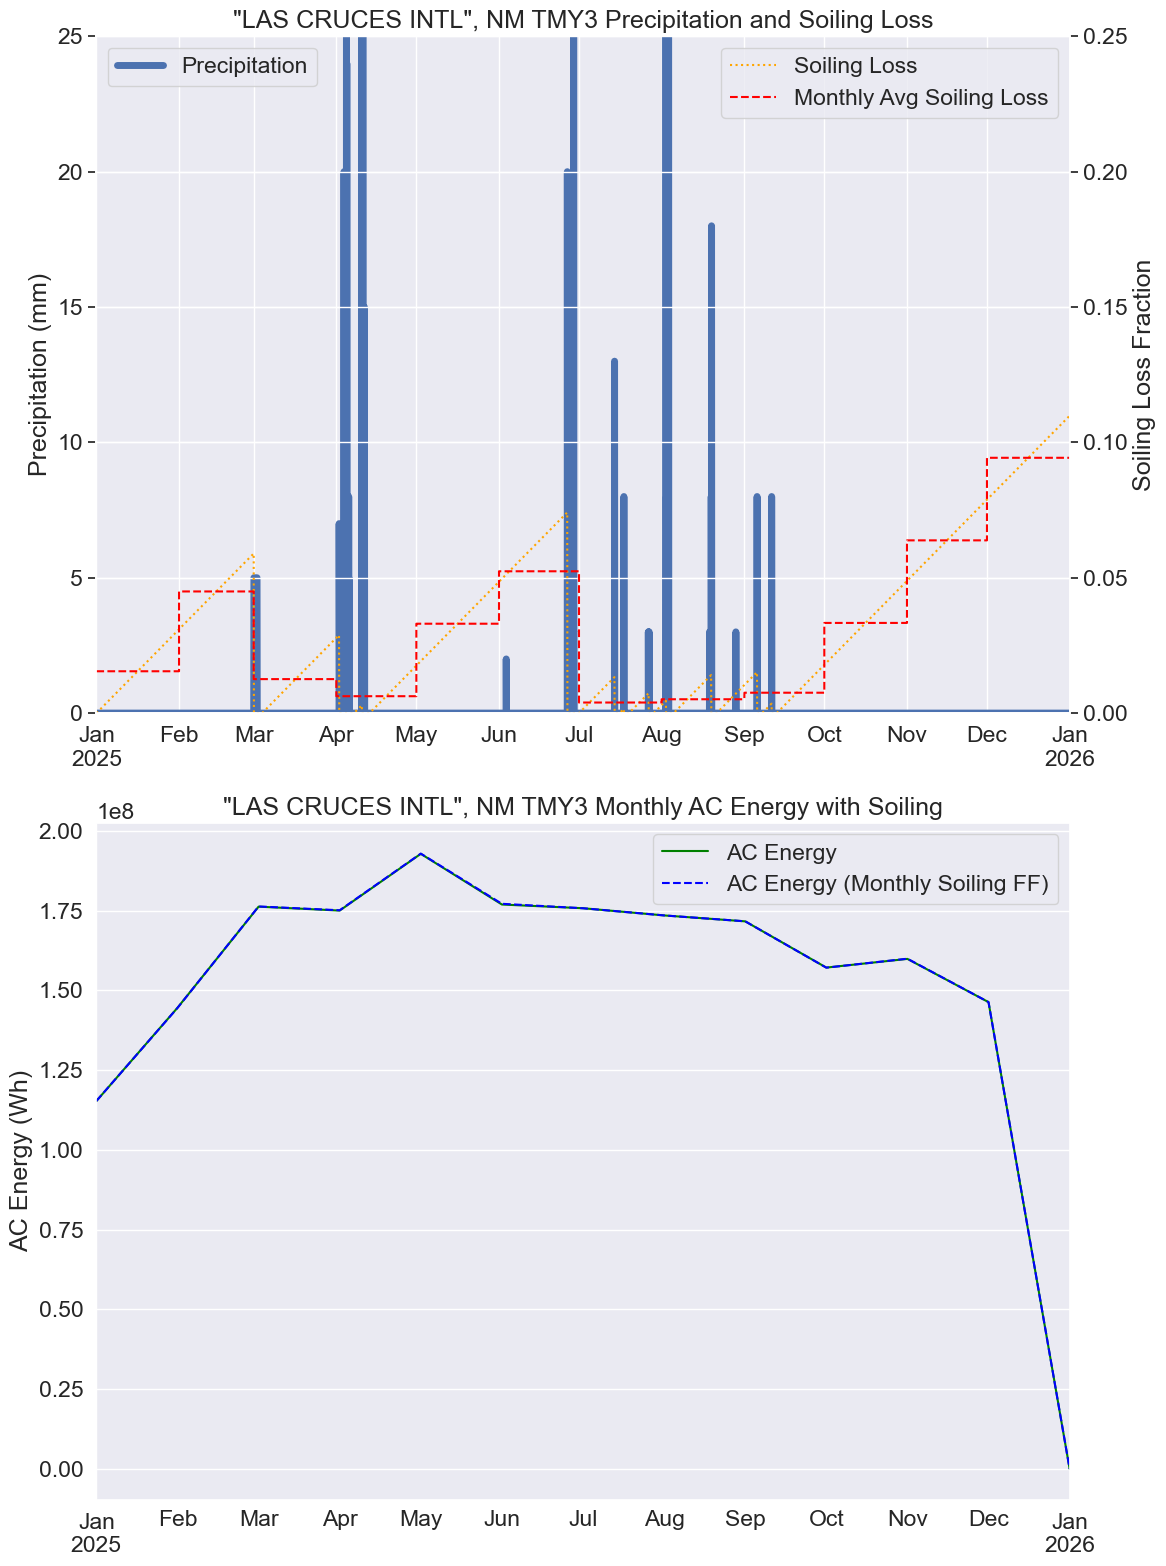

In [22]:
calculate_monthly_soiling_ff_impact("722695TYA.CSV")

In [23]:
def calculate_monthly_soiling_ff_impact_noplots(tmy3filename):
    weather_data, meta = pvl.iotools.read_tmy3(
        filename=(alltmy3 / tmy3filename),
        coerce_year=2025)

    # print(meta)
    name = meta['Name']
    state = meta['State']

    soiling = get_soiling_profiles(weather_data)

    fixedtilt = get_fixedtilt_energy(
        weather_data, meta, soiling)

    monthly_soil = soiling.resample('ME').mean().shift(freq='-1M').shift(freq='1D')
    monthly_soil = monthly_soil.resample('H').ffill().iloc[:-1]
    monthly_ff = get_fixedtilt_energy(
        weather_data, meta, monthly_soil)

    # f, a = plt.subplots(2, 1, figsize=(12, 16))

    # weather_data['Lprecip depth (mm)'].plot(ax=a[0], linewidth=5, label='Precipitation')
    # atwin = a[0].twinx()
    # soiling.plot(
    #     ax=atwin, color='orange', label='Soiling Loss', linestyle=':')
    # monthly_soil.plot(
    #     ax=atwin, color='red', linestyle='--', label='Monthly Avg Soiling Loss',
    #     drawstyle='steps-post')
    # a[0].set_title(f'{name}, {state} TMY3 Precipitation and Soiling Loss')
    # a[0].set_ylabel('Precipitation (mm)')
    # atwin.set_ylabel('Soiling Loss Fraction')
    # a[0].legend(loc='upper left')
    # atwin.legend(loc='upper right')
    # a[0].set_ylim(0, 25)
    # atwin.set_ylim(0, 0.25)
    # fixedtilt['ac_energy'].resample('ME').sum().plot(
    #     ax=a[1], color='green', label='AC Energy')
    # monthly_ff['ac_energy'].resample('ME').sum().plot(
    #     ax=a[1], color='blue', linestyle='--', label='AC Energy (Monthly Soiling FF)')
    # a[1].set_title(f'{name}, {state} TMY3 Monthly AC Energy with Soiling')
    # a[1].set_ylabel('AC Energy (Wh)')
    # a[1].legend()
    # f.tight_layout()

    # print(f"Total AC Energy (Hourly Soiling FF): {fixedtilt['ac_energy'].sum()}")
    # print(f"Total AC Energy (Monthly Soiling FF): {monthly_ff['ac_energy'].sum()}")
    # print(f"Difference: {fixedtilt['ac_energy'].sum() - monthly_ff['ac_energy'].sum()}")
    # print(f"Percentage Difference: {100 * (1 - monthly_ff['ac_energy'].sum() / fixedtilt['ac_energy'].sum()):.2f}%")
    return (fixedtilt['ac_energy'].sum(),
            monthly_ff['ac_energy'].sum())

C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\3544984960.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_soil = soiling.resample('ME').mean().shift(freq='-1M').shift(freq='1D')
C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\3544984960.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  monthly_soil = monthly_soil.resample('H').ffill().iloc[:-1]
C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\3544984960.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_soil = soiling.resample('ME').mean().shift(freq='-1M').shift(freq='1D')
C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_2716\3544984960.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  monthly_soil = monthly_soil.resample('H').ffill().iloc[:-1]
C:\Users\ADMMIKM\AppData\Local\Tem

array([[<Axes: title={'center': 'Hourly Soiling FF AC Energy'}>,
        <Axes: title={'center': 'Monthly Soiling FF AC Energy'}>],
       [<Axes: title={'center': 'Difference'}>,
        <Axes: title={'center': 'Percentage Difference'}>]], dtype=object)

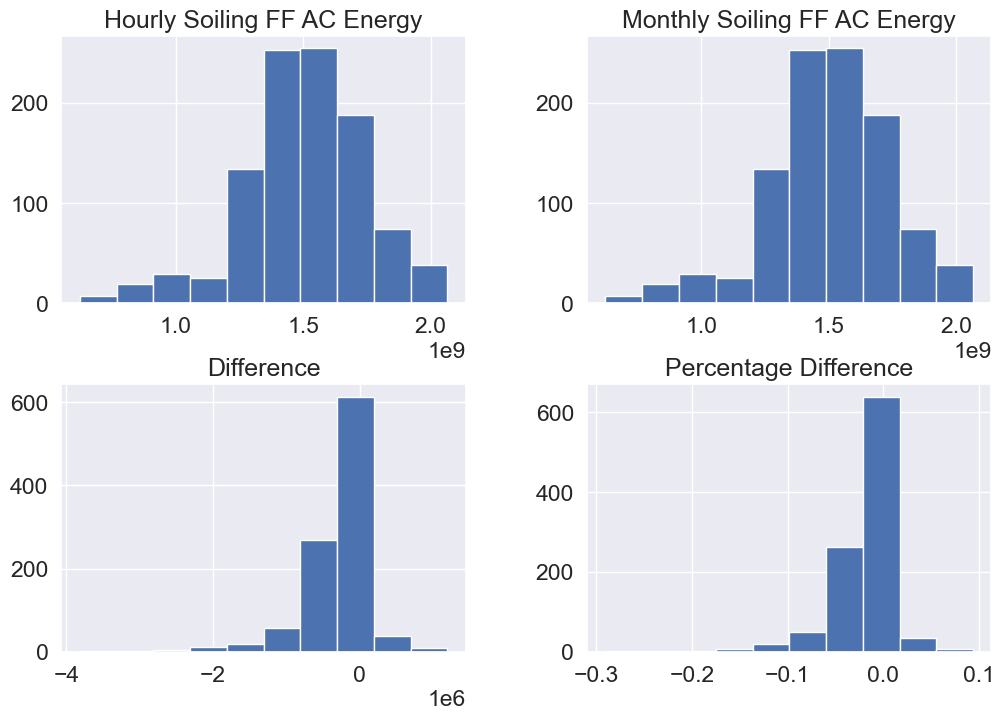

In [24]:
all_results = []
for fn in alltmy3.glob("*.CSV"):
    all_results.append(calculate_monthly_soiling_ff_impact_noplots(fn.name))

all_results = pd.DataFrame(all_results, columns=['Hourly Soiling FF AC Energy', 'Monthly Soiling FF AC Energy'])
all_results['Difference'] = all_results['Hourly Soiling FF AC Energy'] - all_results['Monthly Soiling FF AC Energy']
all_results['Percentage Difference'] = 100 * all_results['Difference'] / all_results['Hourly Soiling FF AC Energy']
all_results.hist()

Text(0.5, 1.0, 'Histogram of Percentage Difference between Hourly and Monthly Soiling FF AC Energy')

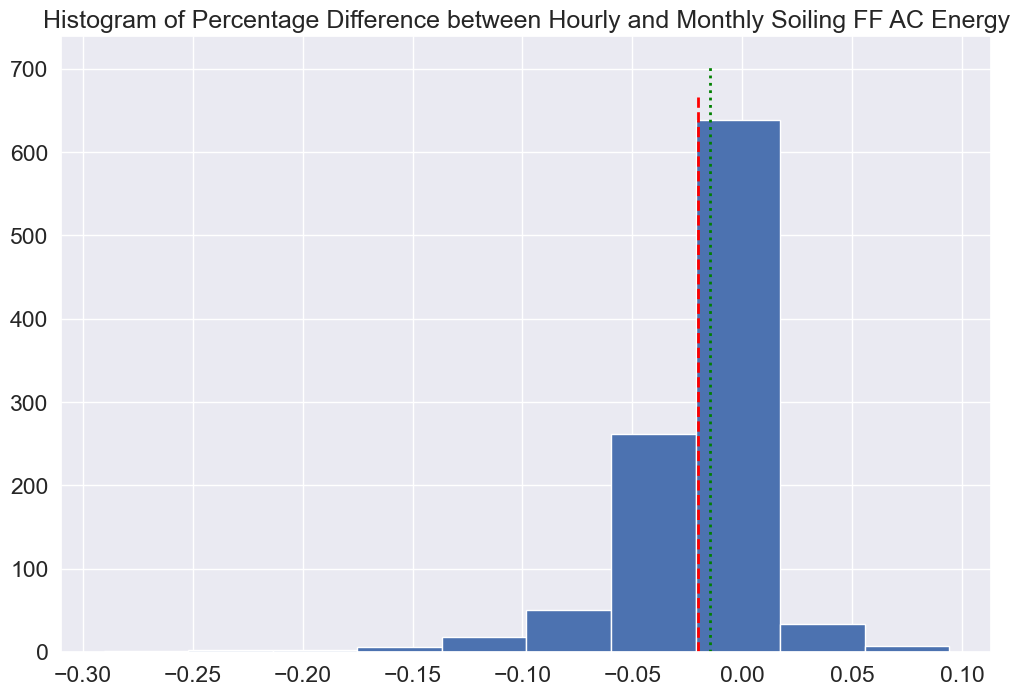

In [ ]:
all_results['Percentage Difference'].hist()
plt.vlines(all_results['Percentage Difference'].mean(), color='red', linestyle='--', label='Mean', ymin=0, ymax=plt.gca().get_ylim()[1], linewidth=2)
plt.vlines(all_results['Percentage Difference'].median(), color='green', linestyle=':', label='Median', ymin=0, ymax=plt.gca().get_ylim()[1], linewidth=2)
plt.title('Histogram of Percentage Difference between Hourly and Monthly Soiling FF AC Energy')

In [29]:
all_results['Percentage Difference'].describe()

count    1020.000000
mean       -0.020273
std         0.031538
min        -0.290530
25%        -0.025930
50%        -0.014656
75%        -0.005929
max         0.094208
Name: Percentage Difference, dtype: float64